## Chapter 8
# Pole-Zero Analysis

In [1]:
import sys
sys.path.append('../')

from ipython_animation import create_animation, DEFAULT_FPS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The frequency response magnitude (amplitude response) at frequency $\omega$ is given by the product of the lengths of vectors draw from the zeros to the point $e^{j\omega T}$ divided by the product of lengths of vectors drawn from the poles to $e^{j\omega T}$.

The phase response is given by the sum of angles of the same zero vectors, subtracted by the angles of the pole vectors.

In [3]:
from matplotlib import patches
from scipy.signal import zpk2tf
from matplotlib import gridspec

def animate_zpk(zpk_for_frame, ymax=1.1):
    animation_length_sec = 8
    num_frames = DEFAULT_FPS * animation_length_sec
    num_cycles = 4

    N = (num_frames) // num_cycles

    height_ratios = [3, 1, 1]
    gs = gridspec.GridSpec(3, 1, height_ratios=height_ratios) 
    
    aspect_ratio = np.sum(height_ratios) / len(height_ratios)
    fig_width = 8
    fig = plt.figure(figsize=(fig_width, fig_width * aspect_ratio))
    
    z_axis = plt.subplot(gs[0]) # zero-pole
    G_axis = plt.subplot(gs[1]) # amplitude response
    P_axis = plt.subplot(gs[2]) # phase response
    
    z_axis.add_patch(patches.Circle((0,0), radius=1, fill=False, color='black', ls='solid', alpha=0.2))
    z_axis.axvline(0, color='0.7'); z_axis.axhline(0, color='0.7')
    z_axis.set_xlabel('Real')
    z_axis.set_xlabel('Imaginary')
    
    zeros, poles, k = zpk_for_frame(0, num_frames)
    zero_markers, = z_axis.plot(zeros.real, zeros.imag,  'o', markersize=9, fillstyle='none', label='zeros', c='orange')
    pole_markers, = z_axis.plot(poles.real, poles.imag, 'x', markersize=9, label='poles', c='blue')
    z_axis.legend()
    zero_lines = [z_axis.plot([zero.real, zero.imag], [0, 0], color='orange')[0] for zero in zeros]
    pole_lines = [z_axis.plot([pole.real, pole.imag], [0, 0], color='blue')[0] for pole in poles]
        
    w = np.linspace(0, 2 * np.pi, N)
    
    G_line, = G_axis.plot(w, np.zeros(N), c='red')
    G_marker = G_axis.scatter([0], [0], s=40, c='red')
    G_axis.set_ylim(0, ymax)
    
    G_axis.set_title('Amplitude response')
    G_axis.set_xlabel('Normalized Frequency (rad / sample)')
    G_axis.set_ylabel('Gain $\\longrightarrow$')
    
    P_axis.set_title('Phase response')
    P_axis.set_xlabel('Normalized Frequency (rad / sample)')
    P_axis.set_ylabel('Phase Shift (rad)')
    
    P_line, = P_axis.plot(w, np.zeros(N), c='green')
    P_marker = P_axis.scatter([0], [0], s=40, c='green')
    P_axis.set_ylim(-np.pi, np.pi)
    P_axis.set_yticks([-np.pi, 0, np.pi])
    P_axis.set_yticklabels(['$-\\pi$', 0, '$\\pi$'])
    
    plt.tight_layout()
    
    def animate(i):
        global pz_for_frame
        w_eval = np.exp(1j * 2 * np.pi * i / N)
        # arbitrarily move zeros and poles around
        z, p, k = zpk_for_frame(i, num_frames)

        i %= w.size # cycles around and sweeps through the same frequencies again

        zero_markers.set_data(z.real, z.imag)
        pole_markers.set_data(p.real, p.imag)
        for zero_i in range(z.size):
            zero = z[zero_i]
            zero_lines[zero_i].set_data([zero.real, w_eval.real], [zero.imag, w_eval.imag])
            for pole_i in range(p.size):
                pole = p[pole_i]
                pole_lines[pole_i].set_data([pole.real, w_eval.real], [pole.imag, w_eval.imag])
                
                # get the frequency response across the whole complex range [0, 2pi]
                B, A = zpk2tf(z, p, k)
                h = np.fft.fft(B, n=N) / np.fft.fft(A, n=N)
                
                G_i = np.prod(np.abs(w_eval - z)) / np.prod(np.abs(w_eval - p))
                G_marker.set_offsets([w[i], np.abs(k) * G_i]) # this...
                G_line.set_ydata(np.abs(h)) # should land ontop of this at w = w[i]
                
                P_i = (p.size - z.size) * np.angle(w_eval) + np.sum(np.angle(w_eval - z)) - (np.sum(np.angle(w_eval - p)))
                P_marker.set_offsets([w[i], P_i]) # this...
                P_line.set_ydata(np.angle(h)) # should land ontop of this at w = w[i]
                
    return create_animation(fig, plt, animate, length_seconds=animation_length_sec)

N = 512
def zpk_for_frame(frame, num_frames):
    return np.array([0.5 + 1j * 0.5, 1]) * (0.995 * np.exp(1j * np.pi * 0.2 / N)) ** frame, np.array([-0.8, 0.6 + 1j * 0.6]) / (np.exp(1j * np.pi * 0.1 / N) ** frame), 1

animate_zpk(zpk_for_frame, ymax=10)

## Pole-Zero Analysis Problems

**1. _Hum Cancellation:_ Design a second-order filter which will completely reject 60 Hz hum, given a sampling rate of 40 KHz.**

We want our filter to have a zero at 60 Hz. For now, let's consider only FIR filters (with no feedback component). We are given the constraint that the filter must be second-order.  The factored form of a second-order FIR filter is

$H(z) = B(z) = (1 - q_1z^{-1})(1 - q_2z^{-1}) = 1 - (q_1 + q_2)z^{-1} + q_1q_2z^{-2}$,

where $q_1$ and $q_2$ are the zeros of the frequency response. If we want the amplitude response to equal zero at normalized frequencies $\omega_{r1}$ and $\omega_{r2}$, we can simply choose complex filter coefficients such that $\frac{q_i}{z} = 1$ when $z = e^{j\omega_{ri}} \implies q_i = e^{j\omega_{ri}}$.

Here is an example for clarity:

In [4]:
from scipy.signal import freqz

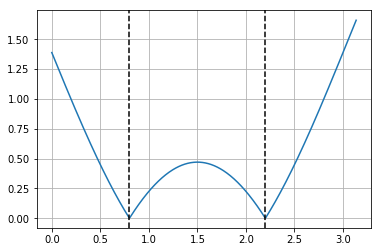

In [5]:
# Pick a couple of arbitrary frequencies to reject.
w1_reject = 0.8
w2_reject = 2.2

N = 512
q1 = np.exp(1j * w1_reject)
q2 = np.exp(1j * w2_reject)

B = [1, -(q1 + q2), q1 * q2]; A = [1]
w, h = freqz(B, A, worN = N)
plt.plot(w, np.abs(h))
for w_reject in [w1_reject, w2_reject]:
    plt.axvline(x=w_reject, linestyle='--', c='k')
plt.grid(True)

If we only want to reject a single frequency (as in this problem), we can set $q_1 = q_2 = q = e^{j\omega_{ri}}$, making our expanded general factored transfer function

$H(z) = 1 - 2qz^{-1} + q^2z^{-2}$.

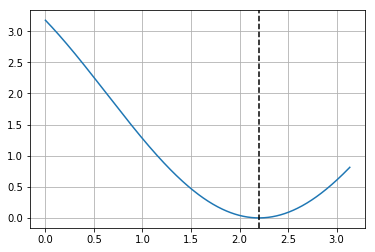

In [6]:
# Only reject a single frequency with a second-order FIR filter with complex coefficients.
w_reject = 2.2

N = 512
q = np.exp(1j * w_reject)

B = [1, -2*q, q ** 2]; A = [1]
w, h = freqz(B, A, worN = N)
plt.plot(w, np.abs(h))
plt.axvline(x=w_reject, linestyle='--', c='k')
plt.grid(True)

We could technically be done here since the problem doesn't stipulate any more constraints, nor does it stipulate how wide the passband should be. However, I don't think this is what the question is after.

If we want a second-order FIR filter with a _real_ coefficient $b_1$ (and $b_2 = 1$), such that the amplitude response is equal to $0$ for normalized frequency $\omega$, we set the amplitude response to $0$ and solve for $b_1$


$\begin{align}
G(\omega) = \left|H(e^{j\omega T})\right| &= \left|1 + b_1e^{-j\omega T} + e^{-j2\omega T}\right|\\
0 &= \left|e^{j2\omega T} + b_1e^{j\omega T} + 1\right|\\
\end{align}$

The only way for the magnitude of a complex number to be $0$ is if the complex number itself is $0$ (I know it's obvious but I needed to think about this for a while and found out the hard way that this works cleanly after solving with trig by expanding using Euler's identity):

$\begin{align}
0 &= e^{j2\omega T} + b_1e^{j\omega T} + 1\\
-e^{j2\omega T} - 1 &= b_1e^{j\omega T}\\
-\frac{e^{j2\omega T} + 1}{e^{j\omega T}} &= b_1\\
-(e^{j\omega T} + e^{-j\omega T}) &= b_1\\
-2\cos(\omega T) &= b_1\\
\end{align}$

Thus, we have $b_1 = -2\cos(\omega T)$.

We are given the sampling interval $T = \frac{1}{f_s} = \frac{1}{40k} s$.

When $f = 60 Hz$,

$\begin{align}
b_1 &= -2\cos(\omega T)\\
&= -2\cos\left(2\pi \frac{60}{40k}\right)\\
&= -2\cos\left(\frac{3\pi}{1000}\right)\\
\end{align}$

Finally, our naive second-order 60 Hz hum-reject-filter for a sampling rate of $f_s=40$ Khz is

$y(n) = x(n) - 2\cos\left(\frac{3\pi}{1000}\right)x(n-1) + x(n-2)$.

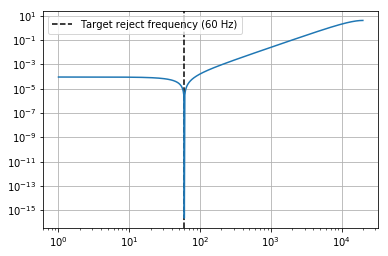

In [7]:
fs = 40_000
B = [1, -2*np.cos(3 * np.pi / 1000), 1]

H = np.fft.fft(B, n=fs)

f = np.arange(0, fs // 2)
plt.axvline(x=60, linestyle='--', c='k', label='Target reject frequency (60 Hz)')
plt.loglog(f, np.abs(H[:fs//2]))
plt.legend()
plt.grid(True)

**How is the frequency response not ideal? What is a simple way to obtain a better frequency response at the price of higher filter order? (Hint: Consider $\lim_\limits{M\to\infty}\left|\cos(\theta_c)\right|^M$.)**

We can see from the plot (and from the equation) that the response is nowhere _near_ flat outside of the "stopband" (nor is it flat anywhere in the spectrum).

Let's get a grip on the hint we're given:

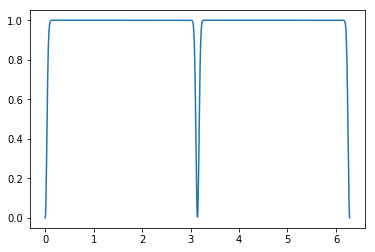

In [8]:
theta = np.linspace(0, 2 * np.pi, 1000)
_ = plt.plot(theta, 1 - np.abs(np.cos(theta)) ** 1000)

This tells us that $1 - \left|\cos(\theta_c)\right|^M$ behaves as what looks like an ideal reject response when $\theta_c = \pi$ as $M \to \infty$. We can choose any frequency to "notch" here by subtracting it from $\theta_c$ above. That is, we should be pretty happy with an amplitude response that looks like

$\begin{align}
G(\omega) &= 1 - \left|\cos(\omega - \omega_r)\right|^M\\
\end{align}$

I scratched my head for awhile thinking of how to design a transfer function to match this kind of response. I ended up finding [this SO answer](https://dsp.stackexchange.com/a/31030/1683) that helped (I still don't _totally_ understand how the hint applies).  The constant `a` in the following implementation controls how close we want to make the frequency response to flat.

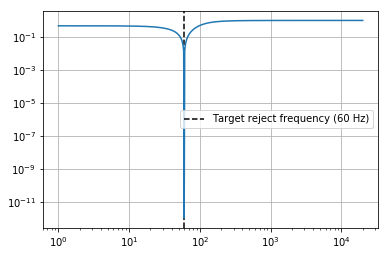

In [9]:
fs = 40_000

f_r = 3 * np.pi / 1000
a = 1.01
B = [1, -2*np.cos(f_r), 1]
A = [1, -2 * a * np.cos(f_r), a ** 2]
H = ((1 + a) / 2) * np.fft.fft(B, n=fs) / np.fft.fft(A, n=fs)

f = np.arange(0, fs // 2)
plt.axvline(x=60, linestyle='--', c='k', label='Target reject frequency (60 Hz)')
plt.loglog(f, np.abs(H[:fs//2]))
plt.legend()
plt.grid(True)

Here is an animation showing the orientation of the poles changing relative to the zeros. As they get closer together, the frequency response gets more flat and the bandwidth of the reject region gets as small as we like:

In [10]:
from scipy.signal import tf2zpk

def zpk_for_frame(frame, num_frames):
    f_r = np.pi / 4
    a = 2 - frame/num_frames
    B = [1, -2*np.cos(f_r), 1]
    A = [1, -2 * a * np.cos(f_r), a ** 2]
    z, p, _ = tf2zpk(B, A)
    return z, p, (1 + a) / 2

animate_zpk(zpk_for_frame)

Since the zeros lie on the unit circle, the response will evaluate to exactly 0 for $\omega = p_n$. As the poles get closer to the zeros, the difference between the product of the blue vectors and the product of the orange vectors gets smaller and smaller, and so their ratio approaches 1. However, until they are exactly equal, the orange (zero) vectors will still asymptotically approach 0 as $\omega \to p_n$, while the poles will still have some positive magnitude, resulting in a ratio (response magnitude) close to 0 (and equal to 0 when $\omega = p_n$).

**2. _Graphical Phase-Response Calculation:_ Define**

$H_p(z) = -p\frac{1-\frac{1}{p}z^{-1}}{1-pz^{-1}}$

**where $p$ is a real number.**

**a) Find the _amplitude response_ $G_p(\omega) \triangleq \left|H_p(e^{j\omega T})\right|$ as a function of $\omega$ and $p$.**

$\begin{align}
G_p(\omega) &\triangleq \left|H_p(e^{j\omega T})\right|\\
&= \left|-p\frac{1-\frac{1}{p}e^{-j\omega T}}{1-pe^{-j\omega T}}\right| = \frac{\left|-p+e^{-j\omega T}\right|}{\left|1-pe^{-j\omega T}\right|} = \frac{\left|1-pe^{j\omega T}\right|}{\left|e^{j\omega T}-p\right|}\\
&= \frac{\left|e^{j\omega T}\left(e^{-j\omega T}-p\right)\right|}{\left|e^{j\omega T}-p\right|} = \left|e^{j\omega T}\right|\frac{\left|e^{-j\omega T}-p\right|}{\left|e^{j\omega T}-p\right|}\\
&= 1\cdot\frac{\left|\overline{e^{j\omega T}-p}\right|}{\left|e^{j\omega T}-p\right|} = 1\\
\end{align}$

**b) Find the _phase response_ $\Theta_p(\omega) \triangleq \angle H_p(e^{j\omega T})$ as a function of $\omega$ and $p$.**

$\begin{array}{ll}
\Theta_p(\omega) &\triangleq \angle H_p(e^{j\omega T})\\
&= \angle\left[-p\frac{1-\frac{1}{p}e^{-j\omega T}}{1-pe^{-j\omega T}}\right]\\
&= \angle\left[e^{j\omega T}\frac{e^{-j\omega T}-p}{e^{j\omega T}-p}\right] &\text{ using the same simplification steps as above}\\
&= \angle e^{j\omega T} + \angle \frac{\overline{e^{j\omega T}-p}}{e^{j\omega T}-p}\\
&= \omega T - \angle \left(e^{j\omega T} - p\right) - \angle \left(e^{j\omega T} - p\right)\\
&= \omega T - 2\angle \left(e^{j\omega T} - p\right)\\
&= \omega T - 2\tan^{-1}\left[\frac{\sin(\omega T)}{\cos(\omega T) - p}\right]\\
\end{array}$

**c) List all poles and zeros of $H_p(z)$.**

$H_p(z)$ has one zero at $z = \frac{1}{p}$ and one pole at $z = p$.

**d) Find the phase response of $H_p(z)$ _graphically_ using its poles and zeros.**

First let's watch an animation with $p$ changing over time:

In [11]:
def zpk_for_frame(frame, num_frames):
    p = 0.8 + ((frame + 1) / (num_frames + 1)) * 0.3
    return np.array([1/p], dtype=complex), np.array([p], dtype=complex), p

animate_zpk(zpk_for_frame)

_More detailed phase-specific animations using the graphical method are explored for the questions below._

**f) Find $\Theta_0(\omega) = \lim_\limits{p\to 0}\Theta_p(\omega)$, assuming $p$ approaches zero from the negative real axis, i.e., $p < 0$. Do this for both the analytical and graphical methods.**

We found that

$\begin{align}
\Theta_p(\omega) = \omega T - 2\tan^{-1}\left[\frac{\sin(\omega T)}{\cos(\omega T) - p}\right].\\
\end{align}$

so,

$\begin{align}
\lim_\limits{p\to 0^-}\Theta_p(\omega) &= \lim_\limits{p\to 0^-}\left[\omega T - 2\tan^{-1}\left(\frac{\sin(\omega T)}{\cos(\omega T) - p}\right)\right]\\
&= \omega T - 2\lim_\limits{p\to 0^-}\tan^{-1}\left[\frac{\sin(\omega T)}{\cos(\omega T) - p}\right]\\
&= \omega T - 2\tan^{-1}\frac{\sin(\omega T)}{\cos(\omega T)}\\
&= \omega T - 2\omega T\\
&= -\omega T.\\
\end{align}$

**f) Find $\Theta_0(\omega) = \lim_\limits{p\to 0}\Theta_p(\omega)$, assuming $p$ approaches zero from the positive real axis, i.e., $p > 0$. Do this for both the analytical and graphical methods.**

$\begin{align}
\lim_\limits{p\to 0^+}\Theta_p(\omega) &= \omega T - 2\lim_\limits{p\to 0^+}\tan^{-1}\left[\frac{\sin(\omega T)}{\cos(\omega T) - p}\right]\\
&= \omega T - 2\tan^{-1}\frac{\sin(\omega T)}{\cos(\omega T)}\\
&= \omega T - 2\omega T\\
&= -\omega T.\\
\end{align}$

We of course get the same results here - but note that technically $tan^{-1}\frac{\sin(x)}{\cos(x)}$ can have different limits from the right and left side (there is a discontinuous jump) whenever $x = \frac{\pi}{2} + \pi N, N \in \mathbb{Z}$:

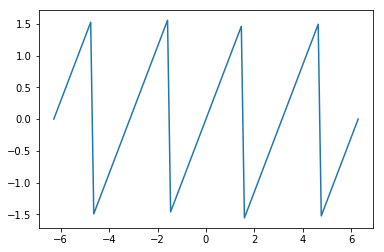

In [12]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
_ = plt.plot(x, np.arctan(np.sin(x) / np.cos(x)))

If we restrict ourselves to the range $\omega T \in (-\pi / 2, \pi/2)$, the above derivations are strictly valid. However, _at_ $\omega T = -\pi/2$, the left- and right-sided limits can technically give different results.

Now let's plot an animation of both of these limits using the "graphical method" (of subtracting the pole angles from the zero angles) _and_ the "analytic method" (using the phase response equation derived above):

In [13]:
fig = plt.figure(figsize=(10, 10))

animation_length_sec = 2
num_frames = animation_length_sec * DEFAULT_FPS

pos_lim_analytic_ax = plt.subplot(411)
neg_lim_analytic_ax = plt.subplot(412)
pos_lim_graphical_ax = plt.subplot(413)
neg_lim_graphical_ax = plt.subplot(414)

pos_lim_analytic_line, = pos_lim_analytic_ax.plot(w, np.zeros(len(w)))
neg_lim_analytic_line, = neg_lim_analytic_ax.plot(w, np.zeros(len(w)))
pos_lim_graphical_line, = pos_lim_graphical_ax.plot(w, np.zeros(len(w)))
neg_lim_graphical_line, = neg_lim_graphical_ax.plot(w, np.zeros(len(w)))

for ax in [pos_lim_analytic_ax, neg_lim_analytic_ax, pos_lim_graphical_ax, neg_lim_graphical_ax]:
    ax.set_xlim(w[0], w[-1])
    ax.set_ylim(-np.pi, np.pi)
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels(['$-\\pi$', 0, '$\\pi$'])

def phase_response_analytic(p):
    return w - 2 * np.arctan2(np.sin(w), np.cos(w) + p)

def phase_response_graphical(p):
    return np.angle(p) + np.angle(np.exp(1j * w) - [1/p]) - np.angle(np.exp(1j * w) - [p])

def animate(i):
    p = 1 - (i / num_frames)
    pos_lim_analytic_line.set_ydata(phase_response_analytic(p))
    neg_lim_analytic_line.set_ydata(phase_response_analytic(-p))
    pos_lim_graphical_line.set_ydata(phase_response_graphical(p))
    neg_lim_graphical_line.set_ydata(phase_response_graphical(-p))

    pos_lim_analytic_ax.set_title('Analytic phase response for $p = %0.3f$' % p)
    neg_lim_analytic_ax.set_title('Analytic phase response for $p = %0.3f$' % -p)
    pos_lim_graphical_ax.set_title('Graphical phase response for $p = %0.3f$' % p)
    neg_lim_graphical_ax.set_title('Graphical phase response for $p = %0.3f$' % -p)

    plt.tight_layout()

create_animation(fig, plt, animate, length_seconds=animation_length_sec)

We can see that the analytic phase reponses _do_ in fact approach the same limit (as expected). The graphical phase responses also agree with each other. However, the graphical phase responses have a positive phase offset compared with the analytic method.

**h) Explain why zeros at infinity can be ignored when computing the phase response of a digital filter using the graphical method.**

The zeros at infinity correspond to pure delay caused by the $0$ or $\pi$ phase response of the real-valued filter gain $k$ ($-p$ in this case). We get the same results as the analytic case when we ignore the phase offset caused by a negative gain, as seen above for this case.

**3. _Direct-Form Coefficient-Stability Region:_ For the two-pole filter $H(z) = 1/(1+a_1z^{-1} + a_2z^{-2})$, find the set of direct-form coefficients $a_1$ and $a_2$ that yield a stable filter, and indicate this set in the $(a_1, a_2)$ plane. [Hint: One closed curve bounds the stability region.]**

This filter will be stable iff both of its poles have magnitude $|p_i| < 1$ (if they are inside the $z$ plane unit circle).

A good first step, then, is to find the factored form of this transfer function. We can use the quadratic formula to find the zeros of the denominator (the poles of the filter):

$\begin{align}
z &= \frac{-a_1 \pm \sqrt{a_1^2 - 4a_2}}{2}\\
&= \frac{-a_1}{2} \pm \sqrt{\left(\frac{a_1}{2}\right)^2 - a_2}\\
\end{align}$

We want

$\begin{array}{ll}
&\left|\frac{-a_1}{2} \pm \sqrt{\left(\frac{a_1}{2}\right)^2 - a_2}\right| &< 1\\
-1 &< -\frac{a_1}{2} \pm \sqrt{\left(\frac{a_1}{2}\right)^2 - a_2} &< 1\\
\end{array}$

I used WolframAlpha to find regions for both the plus and minus cases:

$\begin{array}{ll}
a_1 \geq 2, &-a_1 - 1<a_2<a_1 - 1\\
-2<a_1\geq0, &a_1 - 1<a_2\leq a^2/4\\
0<a_1<2, &-a_1 - 1<a_2\leq a^2/4\\
a_1\leq -2, &a_1 - 1<a_2<-a_1 - 1\\
\end{array}$

I don't really see how this is "one closed curve" and it is not easy to chart. I'm going to skip this (TODO).

**4. _Stability of Linearly INterpolated Direct-Form Filters:_ For the two-pole filter $H(z) = 1/(1+a_1z^{-1}+a_2z^{-2})$, when linearly interpolatin the direct-form coefficients $a_1$ and $a_2$ from one stable setting to another, determine whether the intermediate filters are stable as well. [Hint: The result of the previous problem can be helpful here.]**

TODO

**5. Repeat the previous problem for the three-pole filter $H(z) = 1/(1+a_1z^{-1}+a_2z^{-2} + a_3z^{-3})$.**

TODO

**6. _Step-Down Recursion:_ Derive the _step-down recursion_ of [Eq. (8.6)](https://ccrma.stanford.edu/~jos/fp/Step_Down_Procedure.html) (9.6 in that link) in detail, clearly showing all intermediate steps.**

The equation in question is

$A_{N-1}(z) = \frac{A_N(z) - k_N\tilde{A}_N(z)}{1-k_N^2} = \frac{A_N(z) - z^{-N}k_NA_N(1/z)}{1-k_N^2}$,

where $k_N$ was defined as $k_N \triangleq a_{N,N}$, and the first $N$ in that subscript denotes the current polynomial order being used in the recursive procedure.

$\begin{array}{ll}
\frac{A_N(z) - z^{-N}k_NA_N(1/z)}{1-k_N^2} &= \frac{A_N(z) - z^{-N}a_{N,N}A_N(1/z)}{1-a_{N,N}^2}\\
&= \frac{A_N(z) - a_{N,N}\left[a_{N,N} + a_{N,N-1}z^{-1} + a_{N,N-2}z^{-2} + \cdots + a_{N,2}z^{-(N-2)} + a_{N,1}z^{-(N-1)}+z^{-N}\right]}{1-a_{N,N}^2}\\
&= \frac{\left[1+a_{N,1}z^{-1}+a_{N,2}z^{-2}+\cdots+a_{N,N-1}z^{-(N-1)}+a_{N,N}z^{-N}\right] - \left[a_{N,N}^2 + a_{N,N}a_{N,N-1}z^{-1} + a_{N,N}a_{N,N-2}z^{-2} + \cdots + a_{N,N}a_{N,2}z^{-(N-2)} + a_{N,N}a_{N,1}z^{-(N-1)}+a_{N,N}z^{-N}\right]}{1-a_{N,N}^2}\\
&= \frac{\left[1+a_{N,1}z^{-1}+a_{N,2}z^{-2}+\cdots+a_{N,N-1}z^{-(N-1)}\right] - \left[a_{N,N}^2 + a_{N,N}a_{N,N-1}z^{-1} + a_{N,N}a_{N,N-2}z^{-2} + \cdots + a_{N,N}a_{N,2}z^{-(N-2)} + a_{N,N}a_{N,1}z^{-(N-1)}\right]}{1-a_{N,N}^2}\\
&= \frac{\left[1+a_{N,1}z^{-1}+a_{N,2}z^{-2}+\cdots+a_{N,N-1}z^{-(N-1)}\right] - a_{N,N}^2\left[1 + \frac{a_{N,N-1}}{a_{N,N}}z^{-1} + \frac{a_{N,N-2}}{a_{N,N}}z^{-2} + \cdots + \frac{a_{N,2}}{a_{N,N}}z^{-(N-2)} + \frac{a_{N,1}}{a_{N,N}}z^{-(N-1)}\right]}{1-a_{N,N}^2}\\
&= (TODO: \text{It's clear we've removed a polynomial degree, but how exactly do we define }a_{N-1,n}\text{?} )\\
&= \frac{\left(1-a_{N,N}^2\right)\left[1 + a_{N-1,1}z^{-1} + a_{N-1,2}z^{-2}+\cdots + a_{N-1,N-1}z^{-(N-1)}\right]}{1-a_{N,N}^2}\\
&= 1 + a_{N-1,1}z^{-1} + a_{N-1,2}z^{-2}+\cdots + a_{N-1,N-1}z^{-(N-1)}\\
&= A_{N-1}(z)\\
QED
\end{array}$


**7. 8. ** TODO

**9. The bandwidth of a one-pole filter section (in Hz) was fefined as $B = -\ln(R)/(\pi T)$, where $R$ is the pole radius and $T$ is the sampling interval in seconds. The time-constant of decay (in seconds) for the impulse-response of a one-pole filter was estimated to be $\tau \approx T/(1-R)$. Using these formulas, find a formula giving $\tau$ in terms of $B$ and a formula giving $B$ in terms of $\tau$.**

$\begin{align}
\tau &= -\frac{T}{1-R}\\
&= -\frac{T}{1-e^{-B\pi T}}
\end{align}$

$\begin{align}
B &= -\frac{\ln(R)}{\pi T}\\
&= -\frac{\ln(\frac{\tau-T}{\tau})}{\pi T}\\
\end{align}$

**10. _Complex Cepstrum:_ For each of the $z$ transforms below, find the corresponding complex cepstrum:**

**a) $H(z) = \frac{1-\frac{1}{2}z^{-1}}{1-\frac{1}{3}z^{-1}}$**

Since the pole and zero are both _inside_ the unit circle, we can express the cepstrum as

$\begin{align}
\tilde{h}(n) &= \begin{cases}\begin{array}{ll}\ln(g), &n=0\\ \sum_\limits{i=1}^{N}\frac{p_i^n}{n} - \sum_\limits{k=1}^{M}\frac{q_k^n}{n}, &n=1,2,3,...,\end{array}\end{cases}\\
&= \begin{cases}\begin{array}{ll}\ln(1), &n=0\\ \frac{\left(\frac{1}{3}\right)^n}{n} - \frac{\left(\frac{1}{2}\right)^n}{n}, &n=1,2,3,...,\end{array}\end{cases}\\
&= \begin{cases}\begin{array}{ll}\ln(1), &n=0\\ \frac{3^{-n} - 2^{-n}}{n}, &n=1,2,3,...\end{array}\end{cases}\\
\end{align}$

**b) $H(z) = -z^{-1}$**

Going back to the original definition of the complex cepstrum,

$\begin{align}
\tilde{h}(n) &= \frac{1}{2\pi}\int_\limits{-\pi}^{\pi}\ln\left[H(e^{jw})\right]e^{j\omega n}d\omega\\
&= \frac{1}{2\pi}\int_\limits{-\pi}^{\pi}\ln\left[-e^{-jw}\right]e^{j\omega n}d\omega\\
&= \frac{\sin(\pi n) - \pi n}{\pi n^2}
\end{align}$

**c) $H(z) = \frac{1-2z^{-1}}{1-3z^{-1}}$**

This transfer function has a single zero and a single zero which are both _outside_ the unit circle, so can express the cepstrum as

$\begin{align}
\tilde{h}(n) &= \begin{cases}\begin{array}{ll}\ln(1) + \ln\left(\frac{-z}{3}\right) - \ln\left(\frac{-z}{2}\right), &n=0\\ \frac{3^{n} - 2^{n}}{n}, &n=1,2,3,...\end{array}\end{cases}\\
\end{align}$

**d) $H(z) = \frac{\left(1-\frac{1}{2}z^{-1}\right)\left(1-2z^{-1}\right)}{\left(1-\frac{1}{3}z^{-1}\right)\left(1-3z^{-1}\right)}$**

$\begin{align}
\tilde{h}(n) &= \begin{cases}\begin{array}{ll}\ln(1) + \ln\left(\frac{-z}{3}\right) - \ln\left(\frac{-z}{2}\right), &n=0\\ \frac{3^{-n}}{n} + \frac{3^{n}}{n} - \frac{2^{n}}{n} - \frac{2^{-n}}{n}, &n=1,2,3,...\end{array}\end{cases}\\
&= \begin{cases}\begin{array}{ll}\ln(1) + \ln\left(\frac{-z}{3}\right) - \ln\left(\frac{-z}{2}\right), &n=0\\ \frac{3^{-n} + 3^{n} - 2^{n} - 2^{-n}}{n}, &n=1,2,3,...\end{array}\end{cases}\\
\end{align}$
